# Supplemental Figures

## Setup

### imports

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
    format_small_plot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups
)
from tabulate import tabulate
import re

## load data

In [87]:
DATA_PATH = "../../dms_3d_features/data"

In [114]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df1 = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues1.json")
df_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
# generate natural log of DMS
with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
#df = df.query("r_data_outlier == False").copy()

df_bp_details = pd.read_csv(f"../../dms_3d_features/resources/csvs/wc_details.csv")
df_bp_details = df_bp_details.query("flanking_pairs == 'YES'")
df_bp_details["ln_r_data"] = np.log(df_bp_details["r_data"])
df_bp_details["ln_r_data"].replace(-np.inf, -9.8, inplace=True)

df_pdb = df_pdb.query("r_data_outlier == False").copy()
df_sasa = pd.read_csv(f"{DATA_PATH}/pdb-features/sasa_new.csv")
df_sasa["m_sequence"] = df_sasa["m_sequence"].apply(lambda x: x.replace("&", "_"))

# merge and remove extra pdb res
df_sasa_merge = pd.merge(df_pdb, df_sasa, on=["m_sequence", "r_nuc", "pdb_r_pos", "pdb_path"])
df_sasa_merge = df_sasa_merge.query("not ln_r_data.isnull()")

df_ratio = pd.read_csv(
    f"{DATA_PATH}/pdb-features/non_canonical_atom_distances.csv"
)
df1 = df1.query("r_data_outlier == False").copy()
df_wc = df1.query("r_type == 'Flank-WC'").copy()

df_wc.sort_values("ln_r_data", inplace=True, ascending=False)

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/196546271.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/196546271.py:23: FutureWarning: A value is tr

In [4]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [5]:
def get_dataframe_with_specific_data_values(df_construct: pd.DataFrame, df_construct_2, value: float) -> pd.DataFrame:
    """
    Merges two DataFrames on the 'name' column and filters for rows where both 'data' values are less than 0.001.

    This function takes two DataFrames, each containing 'name' and 'data' columns, and merges them on the 'name' column. 
    It then compares the 'data' values from both DataFrames row by row, selecting only the pairs where both values are less 
    than 0.001. The result is a new DataFrame with the filtered 'data_1' and 'data_2' columns.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            if d1 < value and d2 < value:
                data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

In [6]:
def plot_feature_scatterplots(df, feature_columns, target_column) -> None:
    """
    Plots scatter plots for each feature against the target variable, including best fit lines and R^2 values.

    This function creates a grid of scatter plots where each plot corresponds to a feature from the 
    `feature_columns` plotted against the `target_column`. For each plot, a linear regression line 
    is fitted and displayed, along with the R^2 value as an annotation.

    Args:
        df (pandas.DataFrame): The input dataframe containing the features and target column.
        feature_columns (list): A list of column names representing the features to be plotted.
        target_column (str): The name of the target column against which each feature is plotted.
    """
    n_features = len(feature_columns)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
    for idx, feature in enumerate(feature_columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        ax.scatter(df[feature], df[target_column], s=1)

        # Reshape x for sklearn
        x = np.array(df[feature]).reshape(-1, 1)
        y = np.array(df[target_column])

        # Linear regression model
        model = LinearRegression()
        model.fit(x, y)

        # Get the slope and intercept of the line
        slope = model.coef_[0]
        intercept = model.intercept_

        # Generate x values for the best fit line
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept

        # Plot the best fit line
        ax.plot(x_fit, y_fit, color="black", label="Best fit line", lw=1)

        # Calculate Pearson correlation coefficient and R^2
        r, _ = pearsonr(x.flatten(), y)
        r_squared = r**2

        # Add R^2 annotation
        ax.text(
            0.03,
            0.97,
            f"$R^2 = {r_squared:.3f}$",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment="top",
        )
        ax.set_xlabel(feature.capitalize())
        ax.set_ylabel("ln(Mut. Frac.)")
    
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

In [7]:
def calculate_sasa_percentages(df_non_wc_pair, sasa_thresholds=[2]):
    results = []
    for threshold in sasa_thresholds:
        below_threshold = (
            df_non_wc_pair[df_non_wc_pair["sasa_0_5"] < threshold].groupby("cat").size()
        )
        total = df_non_wc_pair.groupby("cat").size()
        percentage = (below_threshold / total * 100).round(2)

        results.append(percentage.rename(f"Percent_below_{threshold}"))

    result_df = pd.concat(results, axis=1).fillna(0)
    result_df["Count"] = df_non_wc_pair.groupby("cat").size()

    headers = ["Category"] + list(result_df.columns)
    table_data = [[index] + row.tolist() for index, row in result_df.iterrows()]

    return tabulate(table_data, headers=headers, tablefmt="pipe", floatfmt=".2f")

In [8]:
def figure_outlier(df_motif, ax, seq):
    
    plot_motif_boxplot_stripplot(df_motif, ax=ax)
    for pos in df_motif['r_loc_pos'].unique():

        data_at_pos = df_motif[df_motif['r_loc_pos'] == pos]['r_data']
        
        q1 = data_at_pos.quantile(0.25)
        q3 = data_at_pos.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers = data_at_pos[(data_at_pos < lower_bound) | (data_at_pos > upper_bound)]
        
        ax.scatter(
            [pos] * len(outliers),  
            outliers,              
            color="magenta",    
            zorder=3,          
            s=3                  
        )
    
    ax.set_xlabel("Residues", labelpad=2)
    ax.set_ylabel("Mutation Fraction", labelpad=2)

    format_small_plot(ax)

### extra functions

# Plotting

## Supplemental Figure 1: histogram of number of reads per construct

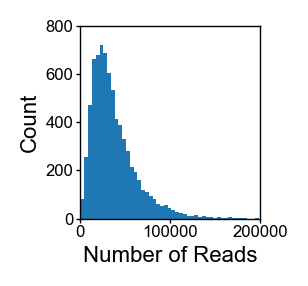

In [9]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plt.hist(df_construct["num_aligned"], bins=100)
ax.set_xlabel("Number of Reads", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim([0, 200000])
ax.set_xticks([0, 100000, 200000])
ax.set_yticks(range(0, 1000, 200))
format_small_plot(ax)

## Supplemental Figure 2: Correlation between DMS reactivity and nomod

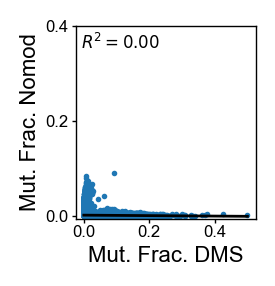

In [10]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)

## Supplemental Figure XXX: DMS correlation between Run 1 and Run 2

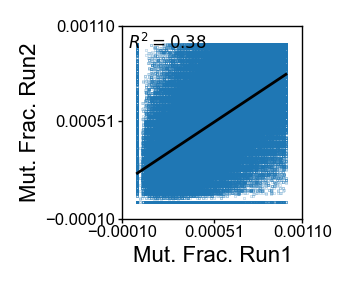

In [11]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = get_dataframe_with_specific_data_values(df_construct, df_construct_2, 0.001)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], size=0.005, ax=ax)
ax.set_xlabel("Mut. Frac. Run1", labelpad=2)
ax.set_ylabel("Mut. Frac. Run2", labelpad=2)
ax.set_xticks([-0.0001, 0.00051, 0.0011])
ax.set_yticks([-0.0001, 0.00051, 0.0011])
format_small_plot(ax)

## Supplemental Figure XXX: reactivity vs standard dev

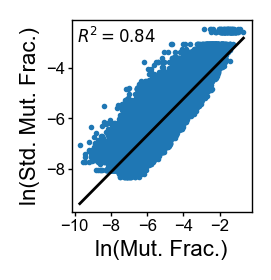

In [12]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
ax.set_xlabel("ln(Mut. Frac.)", labelpad=2)
ax.set_ylabel("ln(Std. Mut. Frac.)", labelpad=2)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_yticks([-10, -8, -6, -4, -2])
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
format_small_plot(ax)

## Supplemental Figure XXX: Correlation between WC pairs and six base pair parameters and RMSD from ideal

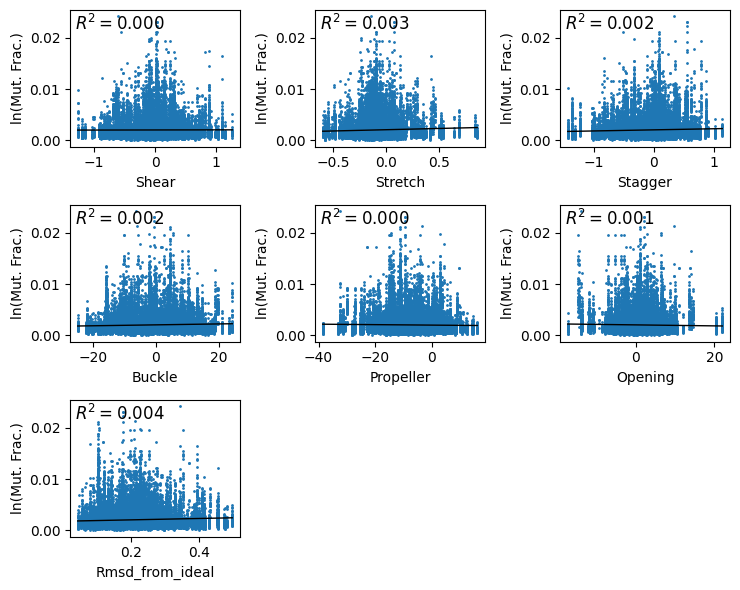

In [13]:
feature_columns = [
    "shear",
    "stretch",
    "stagger",
    "buckle",
    "propeller",
    "opening",
    "rmsd_from_ideal",
]

plot_feature_scatterplots(df_bp_details, feature_columns, 'r_data')
plt.tight_layout()

## Supplemental Figure XXX: Correlation between SASA 0.5 with ln DMS

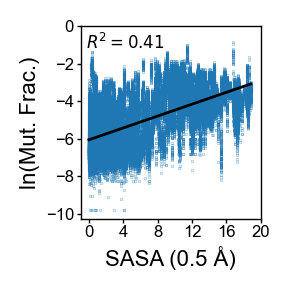

In [16]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plot_scatter_w_best_fit_line(df_sasa_merge["sasa_0_5"], df_sasa_merge["ln_r_data"], size=0.01,ax=ax)
ax.set_ylabel("ln(Mut. Frac.)", labelpad=2)
ax.set_xlabel(f"SASA (0.5 Å)", labelpad=2)
ax.set_xticks([0, 4, 8, 12, 16, 20])
ax.set_yticks([-10, -8, -6, -4, -2, 0])
format_small_plot(ax)

## Suppplemental Table XXX: Residues under 2 A for SASA

In [17]:
df_non_wc_pair = df_sasa_merge.query(
    "r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C') and likely_pair != ''and m_token == '1x1'").copy()
df_non_wc_pair["cat"] = df_non_wc_pair.apply(
    lambda row: f"{row['r_nuc']} in {row['likely_pair'][0]}-{row['likely_pair'][1]}",
    axis=1,
)

print(calculate_sasa_percentages(df_non_wc_pair))

| Category   |   Percent_below_2 |   Count |
|:-----------|------------------:|--------:|
| A in A-A   |             23.29 |  992.00 |
| A in A-C   |             62.43 |  668.00 |
| A in A-G   |             69.25 |  374.00 |
| C in C-A   |             51.66 |  664.00 |
| C in C-C   |             12.06 |  506.00 |
| C in C-U   |              0.00 |  521.00 |


## Supplemental Figure XXX: Correlation plots of the top 10 atomic pair correlations for A-G pairs

In [18]:
df_ratio_ag = df_ratio.query(
    'pair == "A-G" and ln_r_data_mean != ""'
).copy()

In [19]:
df_unique = df_ratio_ag.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/174258286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
2806,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,14.40,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,P,0.518570
5002,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.62,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,C6,0.509953
2196,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,8.92,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,P,C6,0.507597
0,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,15.61,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,P,P,0.506871
4880,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,8.43,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,OP2,C5,0.506294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60367,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.83,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,N9,N1,0.000248
61343,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,10.34,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,N9,N7,0.000069
36455,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,12.31,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,C2,P,0.000058
46947,data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0...,8,15,tHS,7.46,141.182727,41.558651,3.1,-4.090945,0.323147,A-G,C5,C5,0.000006


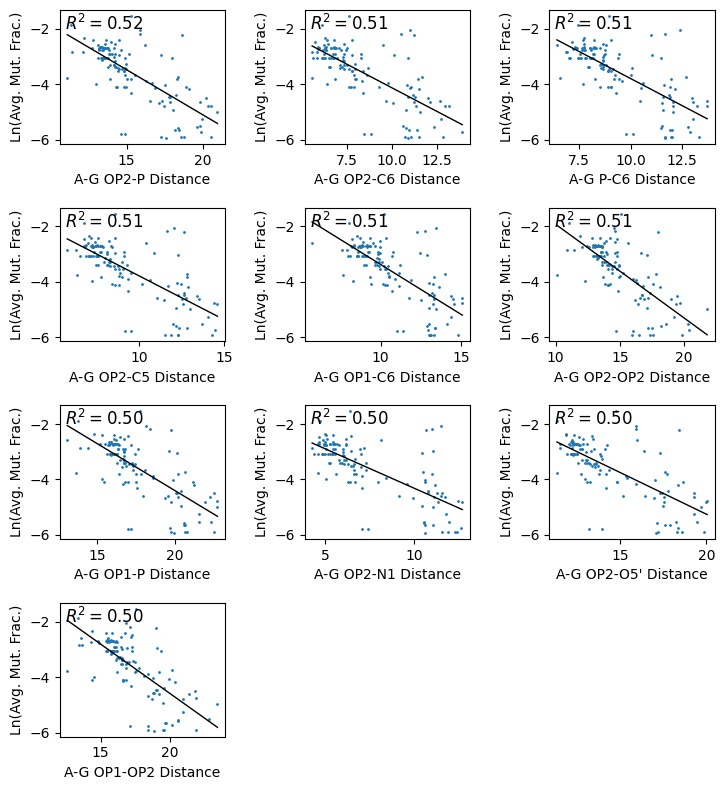

In [20]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(3)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_ratio.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"A-G {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemental Figure XXX: Correlation plots of the top 10 atomic pair correlations for C-A pairs

In [21]:
df_ratio_ca = df_ratio.query(
    'pair == "C-A" and ln_r_data_mean != ""'
).copy()

In [22]:
df_unique = df_ratio_ca.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/1501704007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
103903,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.91,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',C2',0.513945
102847,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.41,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C3',C2',0.496360
103855,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,12.61,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',C1',0.491298
104095,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,9.63,27.956,7.740498,2.0,-4.566327,0.191779,C-A,O3',N3,0.476819
105967,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,10.62,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C2',C1',0.464466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114031,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,14.20,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C5,OP2,0.000105
115135,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,16.82,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,OP1,0.000088
115759,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,9.33,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,C4,0.000025
115039,data/pdbs_w_2bp/ACCC_GACU/NWAY.3WBM.6.ACCCGACU...,5,12,cWW,15.49,27.956,7.740498,2.0,-4.566327,0.191779,C-A,C6,P,0.000020


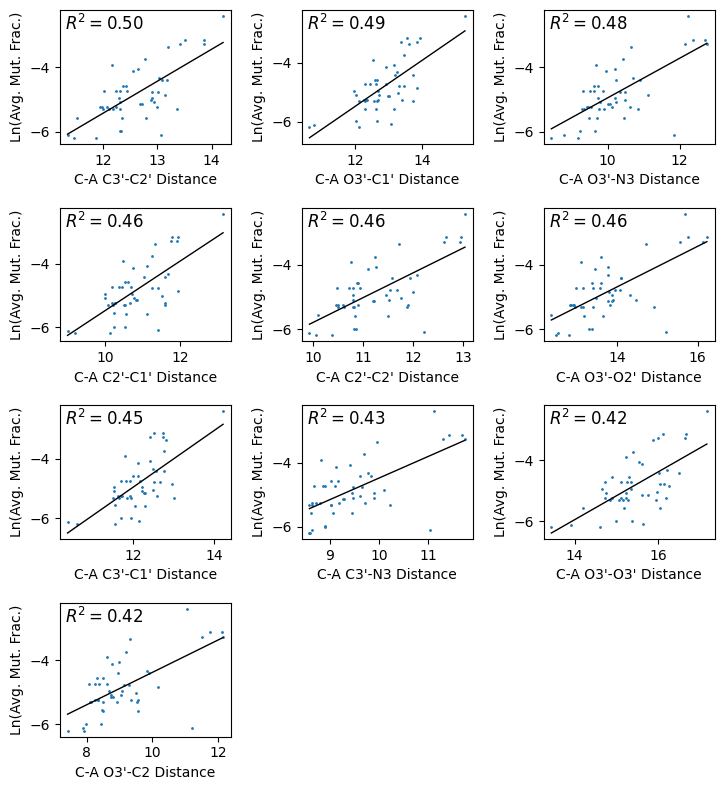

In [23]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_ratio.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"C-A {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemental Figure XXX: Correlation plots of the top 10 atomic pair correlations for C-C pairs

In [24]:
df_ratio_cc = df_ratio.query(
    'pair == "C-C" and ln_r_data_mean != ""'
).copy()

In [25]:
df_unique = df_ratio_cc.drop_duplicates(subset=["pair", "atom1", "atom2", "r2"])
df_unique.sort_values(by="r2", ascending=False, inplace=True)
df_unique

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/734254868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique.sort_values(by="r2", ascending=False, inplace=True)


,pdb_name,pdb_r_pos,pair_pdb_r_pos,pdb_r_bp_type,distance,average_b_factor,normalized_b_factor,pdb_res,ln_r_data_mean,ln_r_data_std,pair,atom1,atom2,r2
121730,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,14.95,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O3',OP2,6.365636e-01
123130,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,12.58,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2',OP2,6.237035e-01
121030,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,13.90,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C3',OP2,6.182270e-01
123830,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,12.91,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O2',OP2,6.056793e-01
121695,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,15.44,44.635,12.722122,3.05,-6.18625,0.278394,C-C,O3',P,6.000941e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126735,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,10.54,44.635,12.722122,3.05,-6.18625,0.278394,C-C,N3,C5',5.134055e-05
125685,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,6.51,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2,O2,2.195199e-05
116760,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,13.09,44.635,12.722122,3.05,-6.18625,0.278394,C-C,P,C6,1.381032e-05
125545,data/pdbs_w_2bp/GCUAAC_GGACCC/NWAY.4QK9.2-4-0....,4,17,cWW,8.93,44.635,12.722122,3.05,-6.18625,0.278394,C-C,C2,C2',2.261676e-06


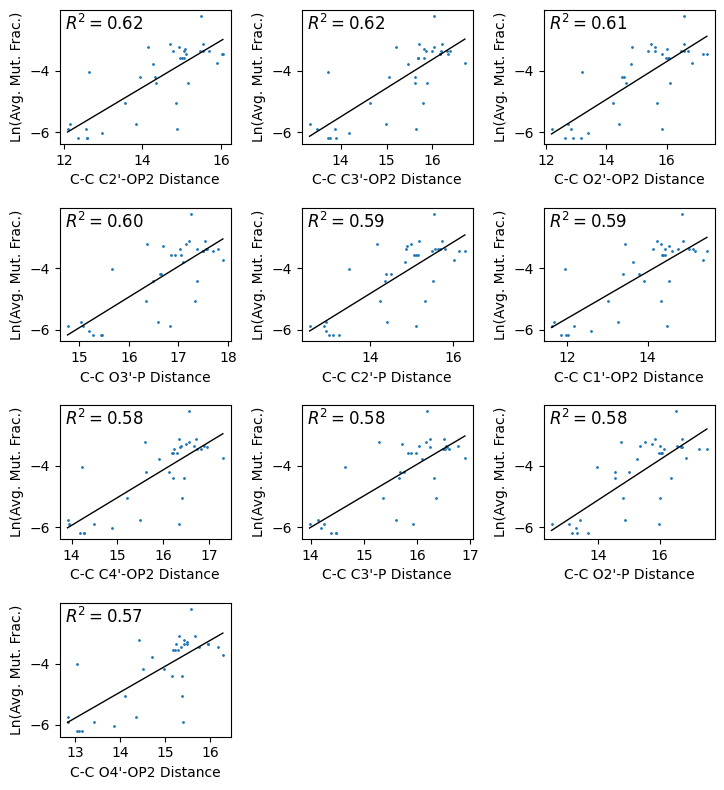

In [26]:
df_top_11 = df_unique.head(11).reset_index(drop=True)
df_top_10 = df_top_11.drop(0)

n_plots = 10
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))
for idx, (i, row) in enumerate(df_top_10.iterrows()):
    row_pos = idx // n_cols
    col_pos = idx % n_cols
    ax = axes[row_pos, col_pos] if n_rows > 1 else axes[col_pos]
    df_plot = df_ratio.query(f'pair == "{row["pair"]}" and atom1 == "{row["atom1"]}" and atom2 == "{row["atom2"]}"').copy()
    plot_scatter_w_best_fit_line(df_plot["distance"], df_plot["ln_r_data_mean"], size=1,ax=ax)
    ax.set_xlabel(f"C-C {row["atom1"]}-{row["atom2"]} Distance")
    ax.set_ylabel("Ln(Avg. Mut. Frac.)")
plt.tight_layout()

for idx in range(n_plots, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

## Supplemntal Figure XXX: Diversity of two-way junctions

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/1841401557.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(twoway,fontsize=6)


Text(0, 0.5, 'Count')

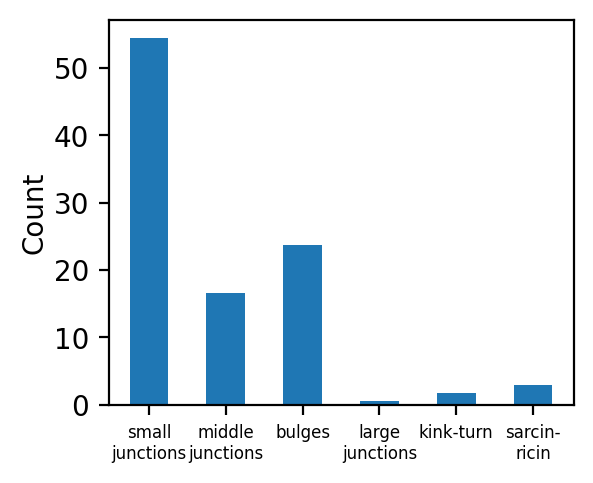

In [27]:
df_unique_pdb = df_pdb.drop_duplicates(subset=["m_sequence"])

small_junctions_combos = ["1x1", "2x2", "2x1", "1x2", "3x1", "1x3", "2x3", "3x2"]
small_junctions = df_pdb[df_pdb["m_token"].isin(small_junctions_combos)]
df_unique_small = small_junctions.drop_duplicates(subset=["m_sequence"])
small_junction_percent = (len(df_unique_small)/len(df_unique_pdb))*100

middle_junction_combos = ["3x3", "4x4", "1x4", "4x1", "2x4", "4x2", "3x4", "4x3", "5x3", "3x5"]
middle_junctions = df_pdb[df_pdb["m_token"].isin(middle_junction_combos)]
df_unique_middle = middle_junctions.drop_duplicates(subset=['m_sequence'])
middle_junction_percent = (len(df_unique_middle)/len(df_unique_pdb))*100

nucleotide_pattern_kt = re.compile(r"[AGCU]+GA[AGCU]+_[AGCU]+GA[AGCU]+")

def matches_nucleotide_pattern_kt(sequence):
    return bool(nucleotide_pattern_kt.match(sequence))

def valid_m_token_kt(m_token):
    m_token_pattern = re.compile(r"(\d+)x(\d+)")
    match = m_token_pattern.match(m_token)
    if match:
        num1, num2 = int(match.group(1)), int(match.group(2))
        return abs(num1 - num2) == 3
    return False

kink_turn = df_pdb[
    (df_pdb['m_sequence'].apply(matches_nucleotide_pattern_kt)) & 
    (df_pdb['m_token'].apply(valid_m_token_kt))
]
df_unique_kt = kink_turn.drop_duplicates(subset=["m_sequence"])
kink_turn_percent = (len(df_unique_kt) / len(df_unique_pdb)) * 100

nucleotide_pattern_srl = re.compile(r"[AGCU]+[AG]+[AGCU]+_[AGCU]+[AG]+[AGCU]+")

def matches_nucleotide_pattern_srl(sequence):
    return bool(nucleotide_pattern_srl.match(sequence))

def valid_m_token_srl(m_token):
    m_token_pattern = re.compile(r"(\d+)x(\d+)")
    match = m_token_pattern.match(m_token)
    if match:
        num1, num2 = int(match.group(1)), int(match.group(2))
        if (num1 > 3)  and (num2 > 3):
            return abs(num1 - num2) == 1
    return False

sarcin_ricin = df_pdb[
    (df_pdb['m_sequence'].apply(matches_nucleotide_pattern_srl)) & 
    (df_pdb['m_token'].apply(valid_m_token_srl))
]
df_unique_srl = sarcin_ricin.drop_duplicates(subset=["m_sequence"])
sarcin_ricin_percent = (len(df_unique_srl) / len(df_unique_pdb)) * 100

bulge_combos = ["1x0", "2x0", "3x0", "5x0"]
bulges = df_pdb[df_pdb["m_token"].isin(bulge_combos)]
df_unique_bulge = bulges.drop_duplicates(subset=["m_sequence"])
bulge_percent = (len(df_unique_bulge)/len(df_unique_pdb))*100

large_junction_percent = 100 - (small_junction_percent + middle_junction_percent + bulge_percent + kink_turn_percent + sarcin_ricin_percent)

twoway = ['small\njunctions', 'middle\njunctions', 'bulges', 'large\njunctions', 'kink-turn', 'sarcin-\nricin']
counts = [small_junction_percent,  middle_junction_percent, bulge_percent, large_junction_percent, kink_turn_percent,  sarcin_ricin_percent]

fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

ax.bar(twoway, counts, width=0.5)
ax.set_xticklabels(twoway,fontsize=6)
ax.set_ylabel('Count', labelpad=2)

## Supplemental Figure XXX: Outliers

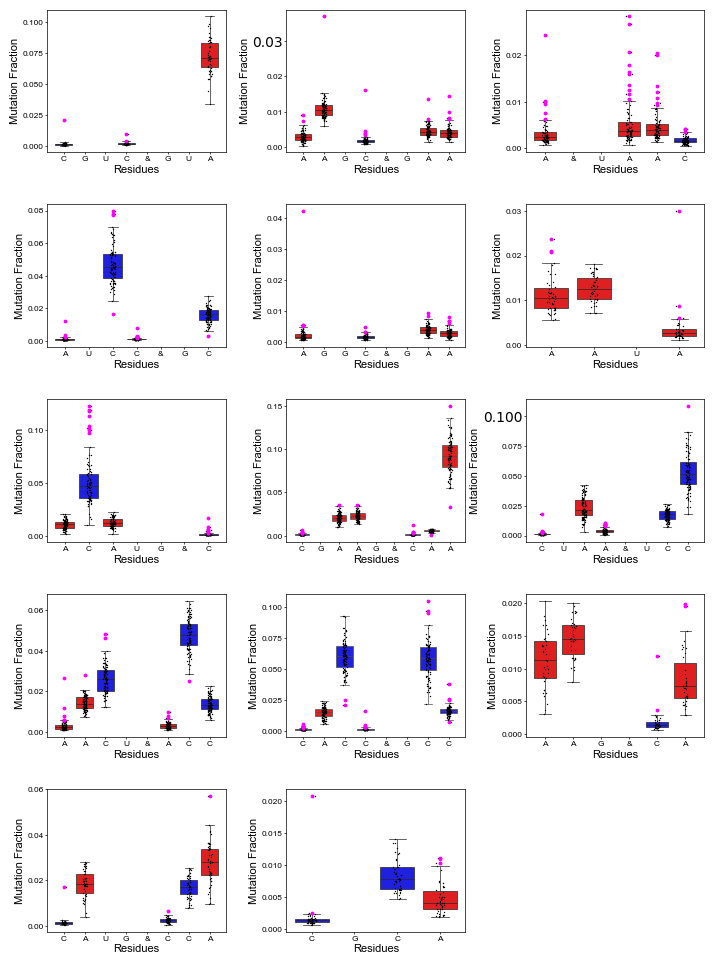

In [28]:
sequences = ['CGUC&GUAG', 'AAGC&GAAU', 'GGGA&UAAC', 'AUCC&GCUU', 'AGGC&GAAU',
             'AAUA&UUGU', 'ACAUG&CU', 'CGAAG&CAAG', 'CUAA&UCCG', 'AACU&ACCU',
             'CACC&GCCG', 'UAAG&CA', 'CAUG&CCAG', 'CGCA&UUGG']

n_plots = len(sequences)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7.5, 2.0 * n_rows))

axes = axes.flatten()

for i, seq in enumerate(sequences):
    df_motif = df[df["m_sequence"] == seq]
    ax = axes[i]
    figure_outlier(df_motif, ax, seq)

for idx in range(n_plots, len(axes)):
    axes[idx].axis('off') 

plt.tight_layout(pad=2.0)
plt.show()

## Supplemental Figure XXX: 

In [89]:
df1["r_type_simple"] = df1["r_type"].replace("Flank-WC", "WC")

In [90]:
def plot_figure_2a(df, ax):
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type_simple",
        data=df,
        hue="r_type_simple",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-\nWC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

<Axes: xlabel='ln(Mutation Fraction)', ylabel='Nucleotide Type'>

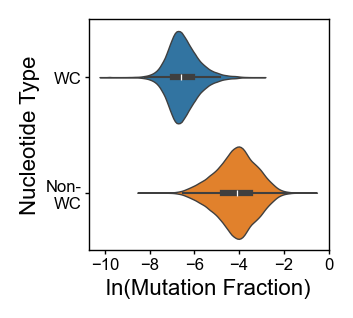

In [91]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2a(df1, ax)

In [92]:
def plot_figure_2b(df, ax):
    df.sort_values("r_type_simple", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type_simple"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Dist. (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Cumulative Dist. (%)'>

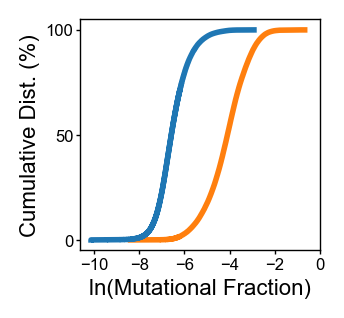

In [93]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2b(df1, ax)

In [94]:
df1["ln_r_data"].replace(-np.inf, -10, inplace=True)
df1["ln_r_data"].describe()

/var/folders/qy/4s0l66g14hn8lxp6p_z_9r100000gq/T/ipykernel_31024/244418767.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1["ln_r_data"].replace(-np.inf, -10, inplace=True)


count    467835.000000
mean         -5.822457
std           1.317967
min         -10.126631
25%          -6.803395
50%          -6.234811
75%          -4.896860
max          -0.691768
Name: ln_r_data, dtype: float64

In [96]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df1["r_type_binary"] = df1["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df1[["ln_r_data"]], df1["r_type_binary"])
# Compute probabilities for the original data
df1["prob_WC"] = model.predict_proba(df1[["ln_r_data"]])[:, 1]
# Display the probabilities
df1.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type_simple", "prob_WC"]]

,ln_r_data,r_type_simple,prob_WC
157982,-10.126631,WC,1.000000
159018,-10.126631,WC,1.000000
159470,-9.903488,WC,0.999999
330469,-9.903488,WC,0.999999
171003,-9.903488,WC,0.999999
...,...,...,...
463230,-1.013022,NON-WC,0.000006
463197,-0.994414,NON-WC,0.000005
105290,-0.972755,NON-WC,0.000005
105301,-0.853363,NON-WC,0.000004


In [97]:
def plot_figure_2c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.axhline(y=0.5, color="black", linestyle="--", lw=0.75)
    ax.axvline(x=-5.45, color="black", linestyle="--", lw=0.75)
    format_small_plot(ax)
    return ax

In [98]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df1["abs_diff"] = (df1["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df1["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df1.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.1379006451


<Axes: xlabel='ln(Mutational Fraction)', ylabel='Probability of WC pair'>

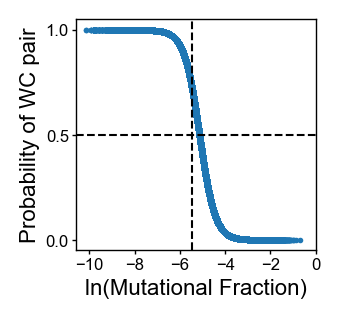

In [99]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2c(df1, ax)

Subplot 1 dimensions: 1.47" wide x 1.23" tall
Subplot 2 dimensions: 1.47" wide x 1.23" tall
Subplot 3 dimensions: 1.47" wide x 1.23" tall


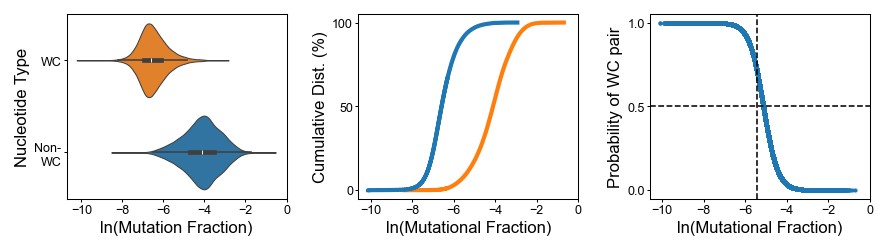

In [100]:
# Create figure with overall size
fig = plt.figure(figsize=(6.00, 1.75), dpi=150)

# Create GridSpec with equal width ratios and spacing between subplots
gs = gridspec.GridSpec(1, 3, figure=fig)

# Add subplots with specified sizes and make them square
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Plot figures
plot_figure_2a(df1, ax1)
plot_figure_2b(df1, ax2)
plot_figure_2c(df1, ax3)

# Adjust layout to prevent overlapping
gs.tight_layout(fig, pad=1.0, w_pad=1.10)

# Get and print subplot dimensions after tight_layout
for i, ax in enumerate([ax1, ax2, ax3], 1):
    bbox = ax.get_position()
    width = bbox.width * fig.get_figwidth()
    height = bbox.height * fig.get_figheight()
    print(f'Subplot {i} dimensions: {width:.2f}" wide x {height:.2f}" tall')

## Supplemental Figure XXX: 

In [101]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


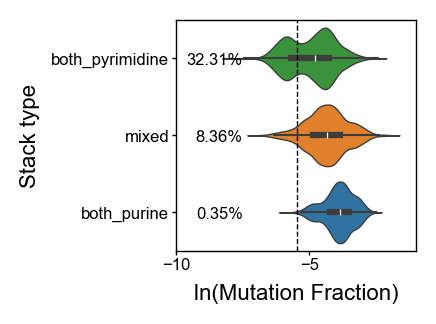

In [103]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cu = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CU'").copy()
df_cu["stack_type"] = df_cu.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cu,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


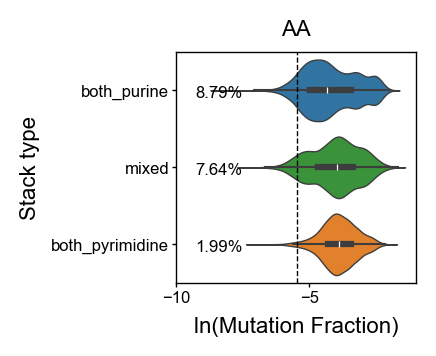

In [106]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
df_aa["stack_type"] = df_aa.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_aa,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_title("AA")
format_small_plot(ax)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


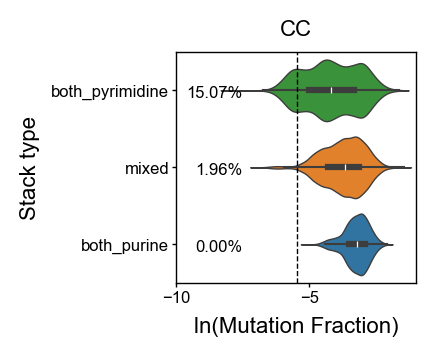

In [107]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_cc = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CC'").copy()
df_cc["stack_type"] = df_cc.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_cc,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_title("CC")
format_small_plot(ax)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


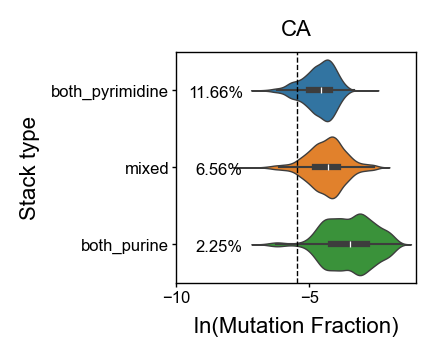

In [110]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ca = df.query("r_nuc == 'C' and r_type == 'NON-WC' and likely_pair == 'CA'").copy()
df_ca["stack_type"] = df_ca.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ca,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_title("CA")
format_small_plot(ax)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


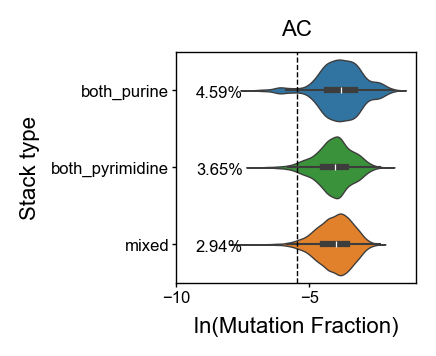

In [111]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ac = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AC'").copy()
df_ac["stack_type"] = df_ac.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ac,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_title("AC")
format_small_plot(ax)

/Users/sandunideenalattha/Desktop/2024_07_09_3d_structure_features_paper/.venv/lib/python3.12/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


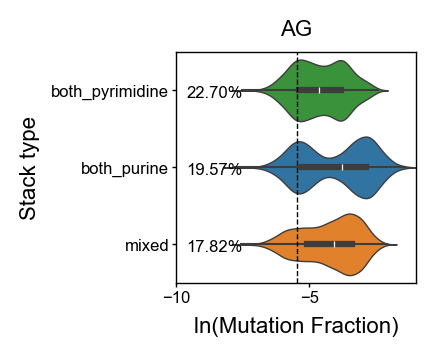

In [112]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_ag = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AG'").copy()
df_ag["stack_type"] = df_ag.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_ag,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.set_title("AG")
format_small_plot(ax)

## Supplemental Figure XXX:

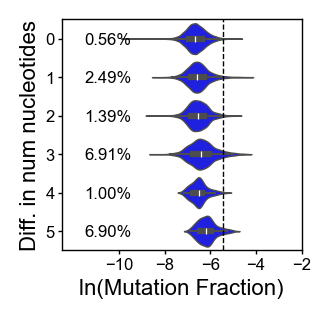

In [117]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
df_pos["side_diff"] = [
    abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df_pos["m_token"]
]
df_pos["side_diff"] = df_pos["side_diff"].astype(str)
df_pos.sort_values("side_diff", inplace=True, ascending=True)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(
    df_pos, "ln_r_data", "side_diff", text_offset=0.75, color="blue", ax=ax
)
ax.set_xlim(-12.5, -3)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Diff. in num nucleotides", labelpad=2)
format_small_plot(ax)

<Axes: xlabel='ln_r_data', ylabel='p5_res'>

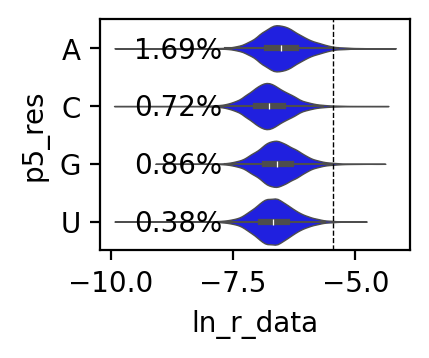

In [125]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p5_res", color="blue", ax=ax)

<Axes: xlabel='ln_r_data', ylabel='p3_res'>

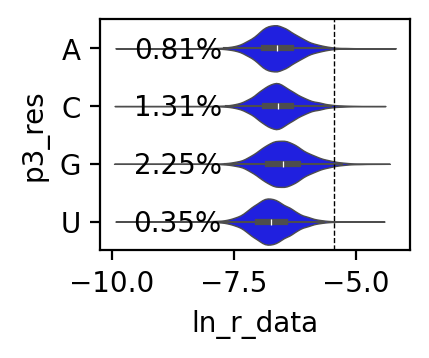

In [127]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "p3_res", color="blue", ax=ax)

<Axes: xlabel='ln_r_data', ylabel='r_stack'>

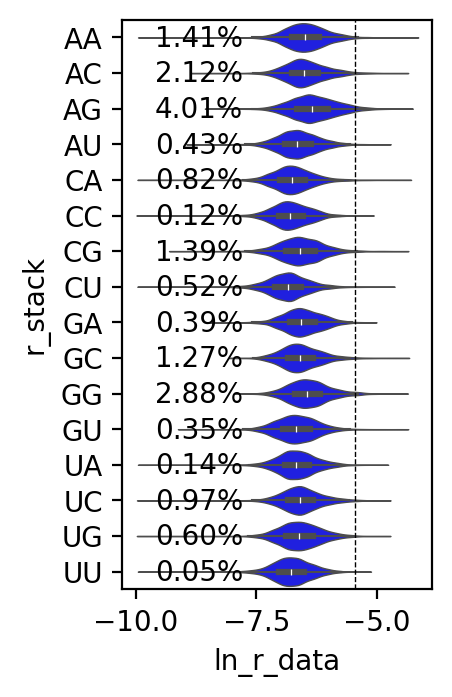

In [128]:
df_pos = df_wc.query("r_nuc == 'C'").copy()
fig, ax = plt.subplots(figsize=(2.0, 3.7), dpi=200)
plot_violins_w_percent(df_pos, "ln_r_data", "r_stack", color="blue", ax=ax)